In [1]:
import os
import itertools
import random
from typing import Sequence

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import torch
from pathlib import Path
from pytorch_lightning import seed_everything
from torch.nn import functional as F
import numpy as np

try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from enum import auto

# from nn_core.common import PROJECT_ROOT
import pickle

print(os.path.abspath(os.curdir))
os.chdir("..")
print(os.path.abspath(os.curdir))
from src.zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align import FeatureExtractor
from src.zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align_hidden import Policy
from src.zeroshotrl.utils.relative import *
from src.zeroshotrl.utils.notebooks import *

import latentis

print(latentis.__version__)

# Relative stuff
from latentis.space import LatentSpace
from latentis.project import RelativeProjector
from latentis.project import relative
from latentis.transform import Centering, StandardScaling

# from latentis.transform.base import StandardScaling, Centering
# from latentis.transform.dim_matcher import ZeroPadding
# from latentis.transform.translate.aligner import MatrixAligner, Translator
# from latentis.transform.translate.functional import (
#     svd_align_state,
# )

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torchvision.models import resnet18
from torchvision import transforms

/Users/antonioricciardi/projects/rl_relrepr_gymnasium/notebooks
/Users/antonioricciardi/projects/rl_relrepr_gymnasium
0.0.7


In [2]:
from latentis.space import LatentSpace
from latentis.utils import seed_everything

# from latentis import transforms
from latentis.estimate.dim_matcher import ZeroPadding
from latentis.estimate.orthogonal import SVDEstimator
from latentis.estimate.linear import LSTSQEstimator
from latentis.translate.translator import LatentTranslator


from src.zeroshotrl.utils.anchoring_methods import get_anchors

In [3]:
from tueplots import bundles

# plt.rcParams.update(bundles.icml2022())
bundles.icml2022()

CMAP = "jet"

# DATA_DIR: Path = PROJECT_ROOT
# print files in the current working directory
print(os.listdir(os.curdir))

['models.dvc', '.DS_Store', 'requirements.txt', 'uv.lock', 'data_collection', 'minigrid_original', '.pre-commit-config.yaml', 'compare_latent_spaces.py', '.ruff_cache', 'experiments', 'collect_data.sh', 'pyproject.toml', '.dvc', 'models', '__pycache__', 'test.py', 'environment_mac.yml', 'README.md', '.gitignore', 'data.dvc', 'ppo.gin', '.venv', 'scripts', 'relative_rl_requirements_mac_old.txt', '.git', 'alignment_indices', 'data', 'runs', 'notebooks', 'requirements_mac.txt', 'wandb', '.dvcignore', 'src']


In [4]:
layers_list = ['enc', 'pol']
layer_to_use = layers_list[1]
color1 = "green"
color2 = "red"
enc1_seed = 2
enc2_seed = 1

obs_path1 = f"data/anchors/CarRacing-v2/rgb_ppo_transitions_{color1}_obs.pkl"
obs_path2 = f"data/anchors/CarRacing-v2/rgb_ppo_transitions_{color2}_obs.pkl"

algo1 = "ppo"
algo2 = "ppo"
env_id1 = "CarRacing-v2"
env_id2 = "CarRacing-v2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Initialize ResNet18 model
resnet_model = resnet18(pretrained=True)
resnet_model.eval()  # Set to evaluation mode

# Define a transform to preprocess the images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(model, images):
    # Preprocess images
    images = torch.stack([preprocess(image) for image in images])
    with torch.no_grad():
        features = model(images)
    return features

/Users/antonioricciardi/projects/rl_relrepr_gymnasium/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/antonioricciardi/projects/rl_relrepr_gymnasium/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# encoder1 = FeatureExtractor()
# encoder2 = FeatureExtractor()
# encoder1.load_state_dict(encoder1_dict)
# encoder2.load_state_dict(encoder2_dict)

In [7]:
from PIL import Image

obs_set_1 = pickle.load(Path(obs_path1).open("rb"))  # [30:2000]
obs_set_2 = pickle.load(Path(obs_path2).open("rb"))  # [30:2000]
print("\n#####\nObs loaded\n#####\n")
# subset_indices = np.random.randint(0, len(obs_set_1), 5000)

print("Converting obs to PIL images")
# convert the (4000, 3, 84, 84) numpy array to a list of PIL images
obs_set_1 = [Image.fromarray((obs * 255).astype(np.uint8).transpose(1, 2, 0)) for obs in obs_set_1]
obs_set_2 = [Image.fromarray((obs * 255).astype(np.uint8).transpose(1, 2, 0)) for obs in obs_set_2]
print("Done converting obs to PIL images\n#####\n")

subset_indices = np.arange(len(obs_set_1))  # [:4000]

# Extract features from the observations
space1 = extract_features(resnet_model, obs_set_1[:1500])
print("Space 1 extracted")
space2 = extract_features(resnet_model, obs_set_2[:1500])
print("Space 2 extracted")


#####
Obs loaded
#####

Converting obs to PIL images
Done converting obs to PIL images
#####

Space 1 extracted
Space 2 extracted


AttributeError: 'Image' object has no attribute 'permute'

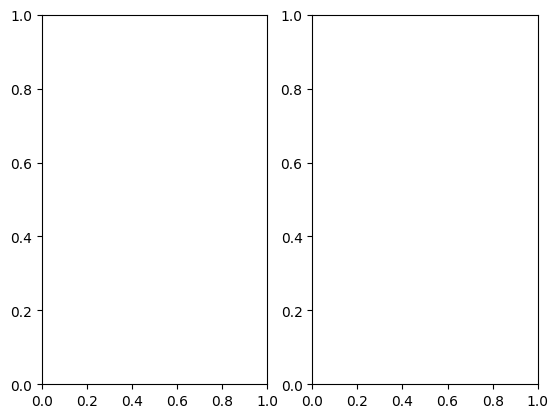

In [8]:
# plot obs_set_1 and obs_set_2 images in a subplot
i = 500
fig, ax = plt.subplots(1, 2)
ax[0].imshow(obs_set_1[i].permute(1, 2, 0))
ax[1].imshow(obs_set_2[i].permute(1, 2, 0))
plt.show()

In [9]:
# compute mean distance between anchors
diff = space1 - space2
print("mean distance between anchors: ", diff.mean())
print(len(space1), len(space2))

mse = torch.nn.MSELoss()
print(mse(space1, space2))

mean distance between anchors:  tensor(-1.6222e-07)
1500 1500
tensor(0.9628)


In [10]:
import latentis.transform


anchoring_method = "random"
# encoder_dir = "models/CarRacing-v2/rgb/green/ppo/absolute/relu/seed_2"
# Randomly sample indices from the spaces
num_anchors = 300  # Number of anchors to sample
subset_indices = np.random.choice(len(space1), num_anchors, replace=False)

# Sample the anchors from the spaces
space1_anchors = space1[subset_indices]
space2_anchors = space2[subset_indices]


translation = LatentTranslator(
    random_seed=42,
    estimator=LSTSQEstimator(),
    # estimator=SVDEstimator(
    #     dim_matcher=ZeroPadding()
    # ),  # SGDAffineTranslator(),#SVDEstimator(dim_matcher=ZeroPadding()),
    source_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()], #None
    target_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()],
)
# translation = LatentTranslation(
#     seed=42,
#     translator=SVDTranslator(),
#     source_transforms=None, #[Transforms.StandardScaling()],
#     target_transforms=None, #[Transforms.StandardScaling()],
# )
space1_anchors = space1_anchors.to(device)  # [:3136]
space2_anchors = space2_anchors.to(device)  # [:3136]
# space1 = LatentSpace(vectors=space1_anchors, name="space1")
# space2 = LatentSpace(vectors=space2_anchors, name="space2")
print("\n##############################################\n")
print(
    f"fitting translation layer between {color1} and {color2} spaces..."
)
translation.fit(source_data=space1_anchors, target_data=space2_anchors)


##############################################

fitting translation layer between green and red spaces...


{}

In [11]:
# print mse and cosine similarity between the two spaces
mse = torch.nn.MSELoss()
cos = torch.nn.CosineSimilarity()
print(
    f"mean squared error between the two spaces: {mse(space1_anchors, space2_anchors)}"
)
print(
    f"cosine similarity between the two spaces: {cos(space1_anchors, space2_anchors).mean()}"
)

mean squared error between the two spaces: 0.9781437516212463
cosine similarity between the two spaces: 0.9066774249076843


In [12]:
space1 = space1[:900]
space2 = space2[:900]

translated_space1 = translation(space1)
print("Computing avg pairwise distances between space1 and space2...")
print(torch.cdist(space1, space2, p=2).mean())

print("\n##############################################\n")
print("Computing avg pairwise distances between translated space1 and space2...")
pairwise_dist_translated = torch.cdist(translated_space1, space2, p=2).mean()
print(pairwise_dist_translated)

# print cosine similarities between space1 and space2, and translated space1 and space2
cos = torch.nn.CosineSimilarity(dim=1)
cos_sim = cos(space1, space2)
print("cosine similarity between space1 and space2: ", cos_sim.mean())

cos = torch.nn.CosineSimilarity(dim=1)
cos_sim = cos(translated_space1, space2)
print(
    "cosine similarity between translated space1 and space2: ",
    cos_sim.mean(),
)

Computing avg pairwise distances between space1 and space2...
tensor(46.7492)

##############################################

Computing avg pairwise distances between translated space1 and space2...
tensor(40.4144)
cosine similarity between space1 and space2:  tensor(0.9059)
cosine similarity between translated space1 and space2:  tensor(0.9743)


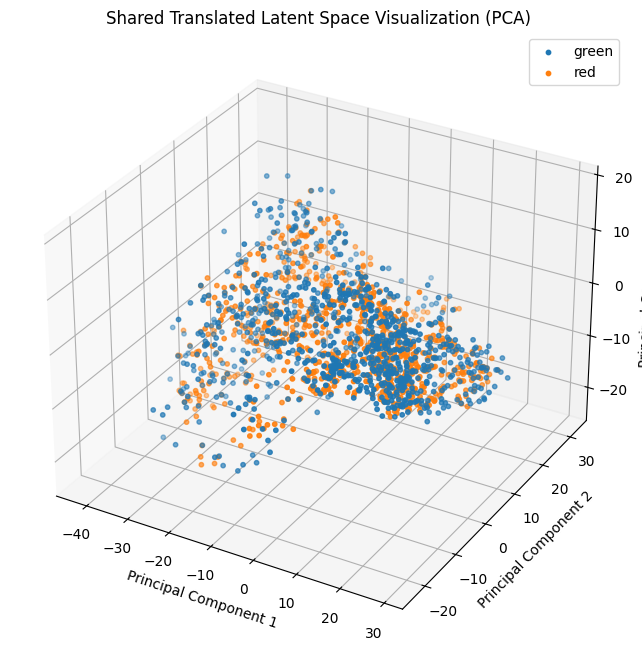

In [13]:
# Assuming obs_set1 and obs_set2 are your two sets of observations
# Combine the observations
translated_space1 = translated_space1[30:]
space2 = space2[30:]
all_obs = np.concatenate((translated_space1, space2), axis=0)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
latent_pca = pca.fit_transform(all_obs)

# Separate the latent encodings back into two sets
latent_pca_set1 = latent_pca[:len(translated_space1)]
latent_pca_set2 = latent_pca[len(space2):]

# Plot the combined latent space in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_pca_set1[:, 0], latent_pca_set1[:, 1], latent_pca_set1[:, 2], label=f'{color1}', s=10)
ax.scatter(latent_pca_set2[:, 0], latent_pca_set2[:, 1], latent_pca_set2[:, 2], label=f'{color2}', s=10)
ax.set_title('Shared Translated Latent Space Visualization (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()
plt.show()